In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from datetime import datetime
today = datetime.now().strftime('%m%d%Y')

In [2]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils

from __init__jupyterlab import *

In [3]:
np.random.seed(0)

## Note
- train a linear model RNA ~ promoter kmers for each cell type
- examine result: ~0.38 r2 spearmanr; ~0.48 r2 on mean across cell types

## to update
- calculate non-redundant kmer
- cross validation

# import data

In [4]:
output_fig = '/cndd2/fangming/projects/scf_enhancers/results/figures/promoter_{{}}_{}.pdf'.format(today)
output_fig

'/cndd2/fangming/projects/scf_enhancers/results/figures/promoter_{}_06162020.pdf'

In [5]:
# get promoter kmer
kmer_nums = [2, 3, 4, 5]

promoter_kmer_list = []
data_path_prom = '/cndd2/ethan/projects/enh_gene_linkage/enhancer_sequence/data/promoter_sort_kmer_{}_bases_1000.tsv'

for k in kmer_nums:
    prom = pd.read_csv(data_path_prom.format(k), sep='\t').set_index('0')
    promoter_kmer_list.append(prom)
promoter_kmers = pd.concat(promoter_kmer_list, axis=1)

In [6]:
f = '/cndd2/ethan/projects/enh_gene_linkage/enhancer_sequence/data/promoter_sort_center_1000.bed'
genes = pd.read_csv(f, sep='\t', header=None)
genes[3] = [i.split('.')[0] for i in genes[3]]
genes['kmer_format'] = '>' +  genes[0] + ':' + genes[1].astype(str) + '-' + genes[2].astype(str)

In [7]:
promoter_kmers = promoter_kmers.loc[genes['kmer_format'].values]
promoter_kmers['gene'] = genes[3].values
kmers = promoter_kmers.set_index('gene')

In [8]:
expression_dir = '/cndd2/ethan/projects/enh_gene_linkage/data/enhancer_ethan38_200520/results/gene_counts_{}'
expression = pd.read_csv(expression_dir.format('10x_cells_v3_ethan38.tsv'),
                         sep='\t').set_index('Unnamed: 0')
expression = expression.drop('Unnamed: 39', axis=1)
expression = snmcseq_utils.logcpm(expression)

In [9]:
expression = expression.reindex(kmers.index)
expression = expression.loc[expression.isna().sum(axis=1)==0] # remove nan
expression.shape

(21739, 38)

In [10]:
kmers = kmers.loc[expression.index]

In [11]:
expression.shape, kmers.shape

((21739, 38), (21739, 1360))

In [12]:
expression.head()

,1-1-1,1-2-1,1-2-2,2-1-1,2-1-2,2-2-1,2-3-1,2-3-2,2-3-3,3-1-1,...,6-4-2,6-5,7-1-1,7-1-2,7-2-1,7-2-2,8-1-1,8-2-1,9-1-1,9-2-1
gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,2.789493,2.881109,2.969154,2.987240,3.000243,3.009621,2.784600,2.918388,2.787187,2.828995,...,3.172320,2.881136,2.802969,2.778116,3.130125,3.151941,2.968148,2.992536,2.620061,2.305264
ENSMUSG00000025900,0.308163,0.326631,0.262048,0.373952,0.294114,0.323501,0.281987,0.090293,0.000000,0.263107,...,0.272758,0.295497,0.332325,0.276188,0.321421,0.277679,0.257277,0.265413,0.277488,0.119084
ENSMUSG00000025902,0.013528,0.002159,0.000000,0.003264,0.002397,0.007805,0.000000,0.000000,0.000000,0.001663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113327,0.000000
ENSMUSG00000033845,1.273354,1.253913,1.275089,1.300341,1.308123,1.262115,1.331863,1.314782,1.299493,1.286630,...,1.302504,1.351081,1.320636,1.376491,1.290156,1.334294,1.196219,1.271679,1.201611,1.486500
ENSMUSG00000025903,0.055976,0.039295,0.052090,0.058182,0.072843,0.053297,0.040583,0.000000,0.000000,0.054734,...,0.033202,0.068929,0.055083,0.082473,0.040095,0.087720,0.000000,0.043486,0.000000,0.000000


In [13]:
kmers.shape

(21739, 1360)

# set up model

In [14]:
X = kmers.values
y = expression.values

ngenes = len(y)
train = np.random.choice(np.arange(ngenes), round(ngenes*0.9), replace=False)
test = np.setdiff1d(np.arange(ngenes), train)

xtrain = X[train, :]
ytrain = y[train, :]

xtest = X[test, :]
ytest = y[test, :]

print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(19565, 1360) (19565, 38)
(2174, 1360) (2174, 38)


# Train model

In [15]:
model = lm.LinearRegression(normalize=True)

model = model.fit(xtrain, ytrain) # a separate model for each cell type
trainhat = model.predict(xtrain)
testhat = model.predict(xtest)

r, p = spearmanr(trainhat.flatten(), ytrain.flatten())
r_test, p_test = spearmanr(testhat.flatten(), ytest.flatten())

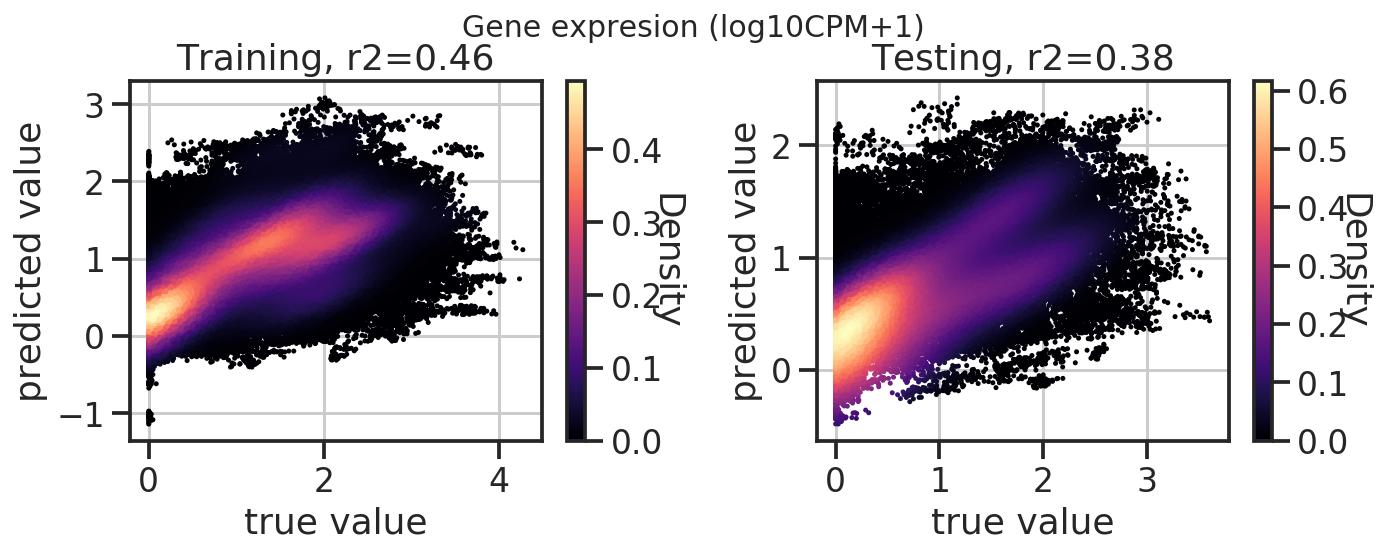

In [21]:
results = [
    {
        'x': ytrain.flatten(), 
        'y': trainhat.flatten(), 
        'title': 'Training', 
        'r': r,
    },
    {
        'x': ytest.flatten(), 
        'y': testhat.flatten(), 
        'title': 'Testing', 
        'r': r_test,
    },
    
]


fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
for ax, result in zip(axs, results):
    z = snmcseq_utils.scatter_density(result['x'], result['y'], p=.0001)
    im = ax.scatter(result['x'], result['y'],
                    c=z, 
                    s=1, cmap='magma', rasterized=True)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Density',
                    rotation=270,
                    labelpad=10)
    ax.set_title("{}, r2={:.2f}".format(result['title'], result['r']**2))
    ax.set_ylabel('predicted value')
    ax.set_xlabel('true value')

fig.suptitle('Gene expresion (log10CPM+1)', fontsize=15)

fig.tight_layout()
snmcseq_utils.savefig(fig, output_fig.format('pred_vs_true'))


# Check per cluster

In [17]:
rtest = []
rtrain = []
for i in range(ytest.shape[1]):
    clust_testhat = testhat[:, i]
    clust_test = ytest[:, i]
    
    clust_trainhat = trainhat[:, i]
    clust_train =  ytrain[:, i]
    
    rtest.append(spearmanr(clust_testhat, clust_test)[0])
    rtrain.append(spearmanr(clust_trainhat, clust_train)[0])

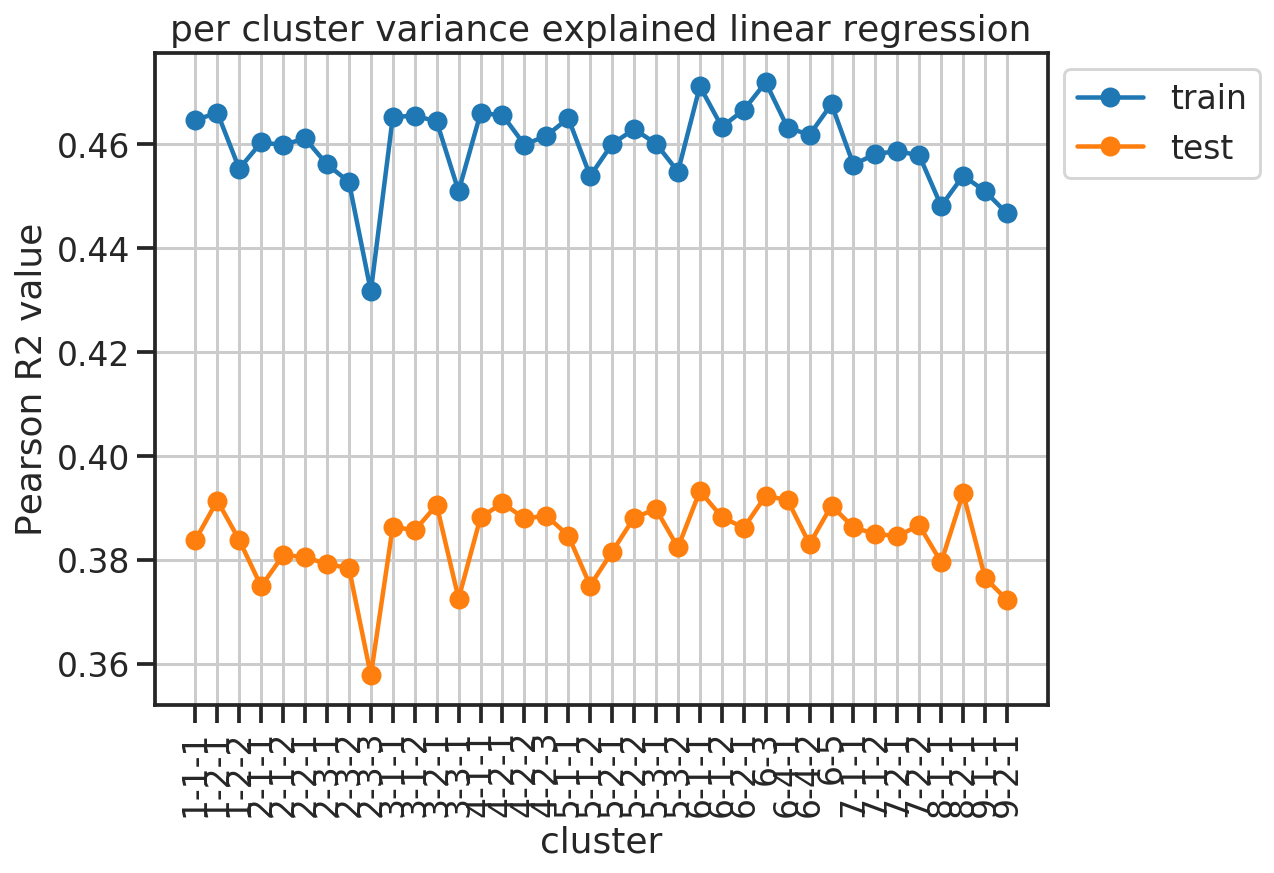

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(len(rtrain)), np.square(rtrain), 'o-', label ='train')
ax.plot(np.arange(len(rtest)), np.square(rtest), 'o-', label ='test')

ax.set_xticks(np.arange(len(rtest)))
ax.set_xticklabels(expression.columns, rotation=90)

ax.set_title('per cluster variance explained linear regression')
ax.set_xlabel('cluster')
ax.set_ylabel('Pearson R2 value')
ax.legend(bbox_to_anchor=(1,1))
snmcseq_utils.savefig(fig, output_fig.format('clster_lin_reg_rval'))

# Check against mean value in tissue

In [19]:
model_ = lm.LinearRegression(normalize=True)

yuse = np.mean(ytrain, axis=1)
yuse_test = np.mean(ytest, axis=1)

model_ = model_.fit(xtrain, yuse)
trainhat_ = model_.predict(xtrain)
testhat_ = model_.predict(xtest)

r_, p_ = spearmanr(trainhat_, yuse)
r_test_, p_ = spearmanr(trainhat_, yuse)

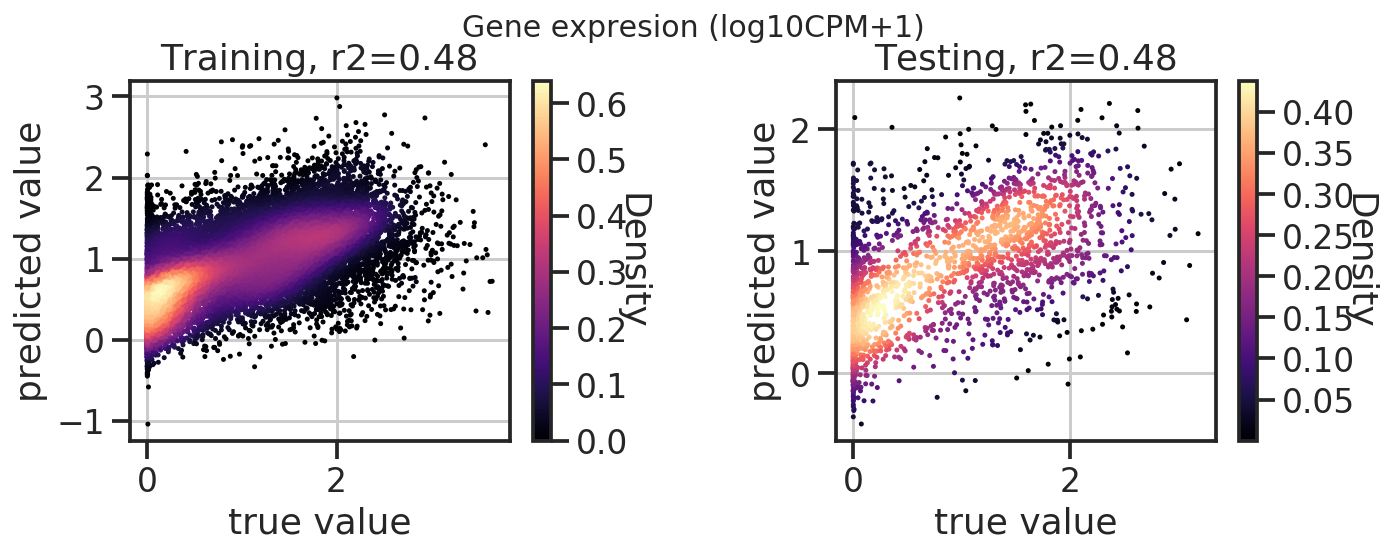

In [22]:
results = [
    {
        'x': yuse, 
        'y': trainhat_, 
        'title': 'Training', 
        'r': r_,
    },
    {
        'x': yuse_test, 
        'y': testhat_, 
        'title': 'Testing', 
        'r': r_test_,
    },
    
]

fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
for ax, result in zip(axs, results):
    z = snmcseq_utils.scatter_density(result['x'], result['y'], p=.01)
    im = ax.scatter(result['x'], result['y'],
                    c=z, 
                    s=1, cmap='magma', rasterized=True)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Density',
                    rotation=270,
                    labelpad=10)
    ax.set_title("{}, r2={:.2f}".format(result['title'], result['r']**2))
    ax.set_ylabel('predicted value')
    ax.set_xlabel('true value')

fig.suptitle('Gene expresion (log10CPM+1)', fontsize=15)

fig.tight_layout()
snmcseq_utils.savefig(fig, output_fig.format('mean_expresion_across_clusters_pred_vs_true'))
